In [1]:
import sys
# Add the parent directory to the system path
sys.path.insert(1, r"C:\Users\sk88\Documents\Python")

#from Function_files.addresses import Init_Directories

import Function_files.data_functions as dat
from Function_files.math_functions import corrected_pulse_area
from Function_files.plotting_functions import plot_scope
from numpy import divide
from TPA import TPA_config_new as config_file
import os

In [2]:
# import config file dictionary
config = config_file.config_params
dir = os.path.join(config['root'], config['file'])
# get indexes for data channels in the excel files
di = config['data_indexes']
# make labels from data indexes
labels = {key:di[key] for key in di.keys() if key != 'time'}

In [3]:
# interogate directory to extract folder and file names
folder_list, file_list = dat.dir_interogate(path=dir, extensions=config['extensions'], exceptions=config['exceptions'])
# create dictionary for indexing folders and files
fol_i = dat.make_index_dict(folder_list)
fil_i = [dat.make_index_dict(file_sub_list) for file_sub_list in file_list]
# assemble reference paths
ref_995_path = dat.search_paths(folder_list, file_list, include=config['refs_995'])
ref_1550_path = dat.search_paths(folder_list, file_list, include=config['refs_1550'])
ref_995_path_list = [os.path.join(dir, x) for x in ref_995_path]
ref_1550_path_list = [os.path.join(dir, x) for x in ref_1550_path]
# extract excel data from the folders
data_path_list = dat.search_paths(folder_list, file_list, config['extensions'])
excel_sets = [[dat.open_csv(os.path.join(dir, data_path)) for data_path in data_paths] for data_paths in data_path_list]

In [4]:
print([pol for pol in config['pol_1550']])
print([(key, value) for (key, value) in fol_i.items()])

['slow', 'fast']
[('1550_HWP_fast', 0), ('1550_HWP_slow', 1), ('solo_995', 2), ('solo_1550', 3)]


In [5]:
# find index of the polarisation values
tpa_pol_1550 = [value for pol in config['pol_1550'] for (key, value) in fol_i.items() if pol in key]
tpa_pol_995 = [value for pol in config['pol_995'] for (key, value) in fol_i.items() if pol in key]
ref_pol_1550 = [value for pol in config['pol_1550'] for (key, value) in fil_i[fol_i['solo_1550']].items() if pol in key]
ref_pol_995 = [value for pol in config['pol_995'] for (key, value) in fil_i[fol_i['solo_995']].items() if pol in key]

# create dictionary for index of polarisation max / min - sp is for the folder index, rsp, rcp are for file indexing
tpa_i = {'tpa_spf': tpa_pol_1550[0],
         'tpa_sps': tpa_pol_1550[1]}

pol_i = {'slow_sp': ref_pol_1550[0],
         'fast_sp': ref_pol_1550[1],
         'slow_cp': ref_pol_995[0],
         'fast_cp': ref_pol_995[1]}

solo_1550


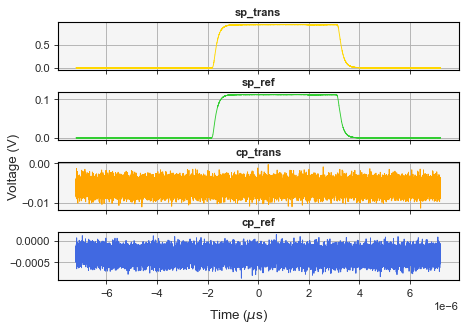

In [6]:
# plot 1550 reference data to check assignment
x = 'solo_1550'
fol = fol_i[x]
fig, ax = plot_scope(excel_sets[fol][0][:,di['time']], [excel_sets[fol][0][:,di['sp_trans']], excel_sets[fol][0][:,di['sp_ref']], excel_sets[fol][0][:,di['cp_trans']], excel_sets[fol][0][:,di['cp_ref']]], titles=labels, multi=True)
print(x)

solo_995


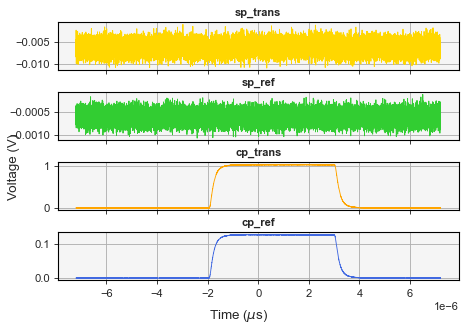

In [7]:
# plot 995 reference data to check assignment
x = 'solo_995'
fol = fol_i[x]
fig, ax = plot_scope(excel_sets[fol][0][:,di['time']], [excel_sets[fol][0][:,di['sp_trans']], excel_sets[fol][0][:,di['sp_ref']], excel_sets[fol][0][:,di['cp_trans']], excel_sets[fol][0][:,di['cp_ref']]], titles=labels, multi=True)
print(x)

1550_HWP_slow


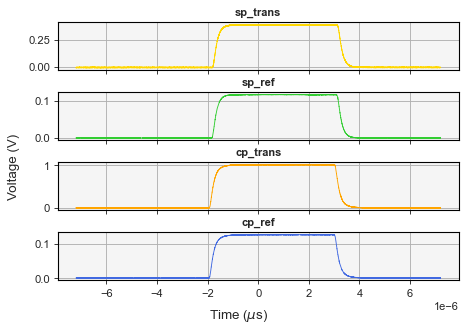

In [8]:
# plot 1550 TPA (fast axis) data to check assignment
name = folder_list[tpa_i['tpa_spf']]
fol = fol_i[name]
fig, ax = plot_scope(excel_sets[fol][0][:,di['time']], [excel_sets[fol][0][:,di['sp_trans']], excel_sets[fol][0][:,di['sp_ref']], excel_sets[fol][0][:,di['cp_trans']], excel_sets[fol][0][:,di['cp_ref']]], titles=labels, multi=True)
print(name)

1550_HWP_fast


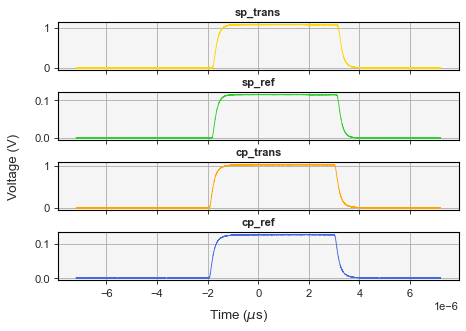

In [9]:
# plot 1550 TPA (slow axis) data to check assignment
name = folder_list[tpa_i['tpa_sps']]
fol = fol_i[name]
fig, ax = plot_scope(excel_sets[fol][0][:,di['time']], [excel_sets[fol][0][:,di['sp_trans']], excel_sets[fol][0][:,di['sp_ref']], excel_sets[fol][0][:,di['cp_trans']], excel_sets[fol][0][:,di['cp_ref']]], titles=labels, multi=True)
print(name)

In [10]:
# indexes for calculations
area_indexes = [di['cp_trans'], di['cp_ref'], di['time']]
# calculate the normalised reference areas
norm_cpf = corrected_pulse_area(excel_sets[fol_i['solo_995']][pol_i['fast_cp']], area_indexes)
norm_cps = corrected_pulse_area(excel_sets[fol_i['solo_995']][pol_i['slow_cp']], area_indexes)
# corrected pulse ratios: (control pulse - leakage)/ reference
corrected = {'cpf_spf': corrected_pulse_area(excel_sets[tpa_i['tpa_spf']][pol_i['fast_cp']], area_indexes, excel_sets[fol_i['solo_1550']][pol_i['fast_sp']]),
            'cpf_sps': corrected_pulse_area(excel_sets[tpa_i['tpa_sps']][pol_i['fast_cp']], area_indexes, excel_sets[fol_i['solo_1550']][pol_i['slow_cp']]),
            'cps_spf': corrected_pulse_area(excel_sets[tpa_i['tpa_spf']][pol_i['slow_cp']], area_indexes, excel_sets[fol_i['solo_1550']][pol_i['fast_sp']]),
            'cps_sps': corrected_pulse_area(excel_sets[tpa_i['tpa_sps']][pol_i['slow_cp']], area_indexes, excel_sets[fol_i['solo_1550']][pol_i['slow_cp']])}

# calculate ratio from pulse areas
ratio = {'cpf_spf': divide(corrected['cpf_spf'], norm_cpf),
        'cpf_sps': divide(corrected['cpf_sps'], norm_cpf),
        'cps_spf': divide(corrected['cps_spf'], norm_cps),
        'cps_sps': divide(corrected['cps_sps'], norm_cps)}

# compile data to save as json dict
save_data = {'area' : corrected,
             'ratio' : ratio}

#dat.write_json(os.path.join(dir, config['file'] + '.json'), save_data)

-216.00390306723745

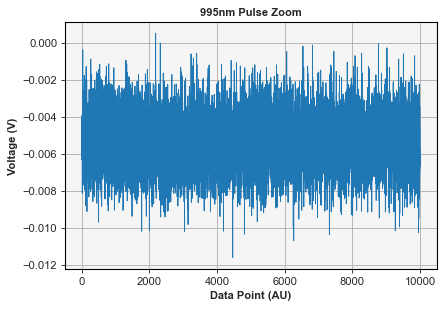

In [27]:
from scipy.integrate import simpson
import matplotlib.pyplot as mp
mp.plot(excel_sets[tpa_i['tpa_spf']][pol_i['fast_sp']][0:10000,di['cp_trans']])
mp.title('995nm Pulse Zoom')
mp.xlabel('Data Point (AU)')
mp.ylabel('Voltage (V)')

simpson(excel_sets[fol_i['solo_1550']][pol_i['fast_sp']][:,di['cp_trans']])

-216.00390306723745

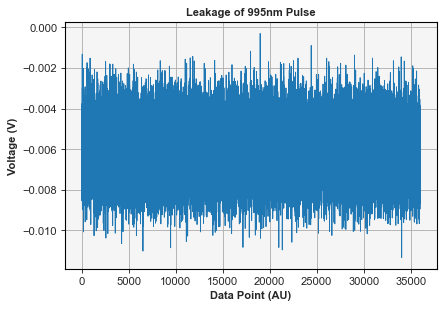

In [25]:
from scipy.integrate import simpson
import matplotlib.pyplot as mp
mp.plot(excel_sets[fol_i['solo_1550']][pol_i['fast_sp']][:,di['cp_trans']])
mp.title('Leakage of 995nm Pulse')
mp.xlabel('Data Point (AU)')
mp.ylabel('Voltage (V)')

simpson(excel_sets[fol_i['solo_1550']][pol_i['fast_sp']][:,di['cp_trans']])

-0.005809616984334125

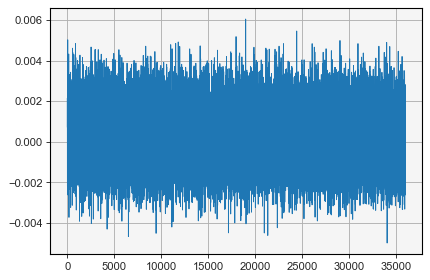

In [41]:
from Function_files.math_functions import bin_data
from numpy import abs

test = excel_sets[fol_i['solo_1550']][pol_i['fast_sp']][:,di['cp_trans']] + abs(bin_data(excel_sets[fol_i['solo_1550']][pol_i['fast_sp']][:,di['cp_trans']]))

mp.plot(test)

bin_data(excel_sets[fol_i['solo_1550']][pol_i['fast_sp']][:,di['cp_trans']], N=100000)

-0.0003330785095957857

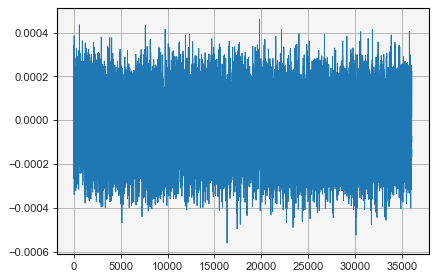

In [42]:
from Function_files.math_functions import bin_data
from numpy import abs

test = excel_sets[fol_i['solo_1550']][pol_i['fast_sp']][:,di['cp_ref']] + abs(bin_data(excel_sets[fol_i['solo_1550']][pol_i['fast_sp']][:,di['cp_ref']]))

mp.plot(test)

bin_data(excel_sets[fol_i['solo_1550']][pol_i['fast_sp']][:,di['cp_ref']], N=100000)